In [4]:
#!/usr/bin/env python
from __future__ import (absolute_import, division, print_function)
from PIL import Image
import six
import os
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import warnings
import numpy as np
import imagehash

warnings.filterwarnings("ignore")

# hashfunc = imagehash.average_hash
# hashfunc = imagehash.phash
# hashfunc = imagehash.dhash
# hashfunc = imagehash.whash
# hashfunc = lambda img: imagehash.whash(img, mode='db4')

def get_hash(img, hashfunc = imagehash.phash):
    im = Image.open(img)
    return hashfunc(im),im.size
    
# images_path = './input/train/'
# train = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]

images_path = './input/valid/'
valid = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]

images_path = './input/test/'
test = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]

files =valid+test#+train

with Pool(cpu_count()) as pool:
    r = list(tqdm(pool.imap(get_hash, files), total=len(files)))

res = dict()
for x,y in zip(files, r):
    res[x] = y
    
np.save("hash_dict_all_p.npy", res)

100%|██████████| 9054/9054 [00:01<00:00, 4707.94it/s]


In [5]:
res[list(res)[1]]

(array([[ True,  True,  True, False, False, False, False,  True],
        [False,  True,  True, False, False, False, False,  True],
        [ True, False, False, False, False,  True,  True,  True],
        [False, False,  True,  True, False,  True,  True, False],
        [ True,  True, False,  True, False,  True,  True, False],
        [ True,  True,  True,  True, False, False,  True, False],
        [False, False, False, False,  True,  True,  True, False],
        [ True,  True, False, False, False, False,  True,  True]]), (258, 256))

In [6]:
def find_match(x):
    for y in res:
        if x==y:
            continue
        if abs(res[x][0]-res[y][0])<5 and res[x][1]==res[y][1]:
            return y
    return -1

l = files
with Pool(cpu_count()) as pool:
    r = list(tqdm(pool.imap(find_match, l), total=len(l)))
    
ans = dict()
for x,y in zip(l, r):
    if y!=-1:
        ans[x] = y
        
np.save("match_dict_all.npy", ans)
len(ans)

100%|██████████| 9054/9054 [00:19<00:00, 459.68it/s]


42

In [26]:
ans = np.load("match_dict_all.npy")
ans = ans.item()
l = []
for x in ans:
    if x.startswith("./input/valid") and ans[x].startswith("./input/valid"):
        print(x[8:], ans[x][8:])
        l.append(x)


valid/0759bb1add1d80dc3514eca25d9798ea - 副本.jpg valid/0759bb1add1d80dc3514eca25d9798ea.jpg
valid/0759bb1add1d80dc3514eca25d9798ea.jpg valid/0759bb1add1d80dc3514eca25d9798ea - 副本.jpg
valid/39de939bdf09aa70a753eda5c86de015 - 副本.jpg valid/39de939bdf09aa70a753eda5c86de015.jpg
valid/39de939bdf09aa70a753eda5c86de015.jpg valid/39de939bdf09aa70a753eda5c86de015 - 副本.jpg
valid/3c83f541b7235ff8d0a1ddd77462eb50 - 副本.jpg valid/3c83f541b7235ff8d0a1ddd77462eb50.jpg
valid/3c83f541b7235ff8d0a1ddd77462eb50.jpg valid/3c83f541b7235ff8d0a1ddd77462eb50 - 副本.jpg
valid/5c25c249-5433-47b9-be00-6cd2d31f48c1___GHLB2 Leaf 8753 - 副本.JPG valid/5c25c249-5433-47b9-be00-6cd2d31f48c1___GHLB2 Leaf 8753.JPG
valid/5c25c249-5433-47b9-be00-6cd2d31f48c1___GHLB2 Leaf 8753.JPG valid/5c25c249-5433-47b9-be00-6cd2d31f48c1___GHLB2 Leaf 8753 - 副本.JPG
valid/98586693-fe1f-4ea0-8e27-4501b61cf09b___GHLB_PS Leaf 23.5 Day 13.jpg valid/c1775bad-7c02-41fb-bb7d-f8df91d60ac3___GHLB_PS Leaf 23.5 Day 13.jpg
valid/a18743d1229537e12bfb7b9a6d88d3

./input/valid/b7b2732c-4481-4cbf-8dd0-8256642baf51___UF.GRC_YLCV_Lab 02455.JPG
./input/test/b7b2732c-4481-4cbf-8dd0-8256642baf51___UF.GRC_YLCV_Lab 02455 - 副本.JPG


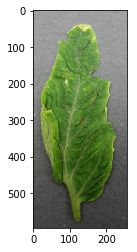

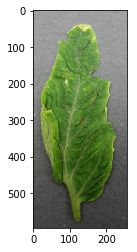

In [42]:
import cv2
from scipy.misc import imread
import matplotlib.pyplot as plt

def show_img(path):
    img = imread(path, mode="RGB")
    plt.imshow(img)
    plt.show()

from random import choice
x = choice(list(ans))
print(x)
print(ans[x])
show_img(x)
show_img(ans[x])

In [66]:
import pandas as pd

# df = pd.read_csv("./input/meta_training.csv", index_col="name")
# df.index = ["train/"+x for x in df.index]
# dt = pd.read_csv("./input/meta_validation.csv", index_col="name")
# dt.index = ["valid/"+x for x in dt.index]
# df = df.append(dt)

df = pd.read_csv("./input/train_prob.csv", index_col="id")

df.tail()

FileNotFoundError: File b'./input/train_prob.csv' does not exist

In [58]:
import json
with open("submit_lgb.json") as f:
    lines = f.readlines()

data = json.loads(lines[0])

d = dict()
for x in data:
    d["./input/test/"+x['image_id']] = x['disease_class']

ans = np.load("match_dict_all.npy")
ans = ans.item()    

k = 0
l = 0

diff = []

for x in d:
    if x in ans:
        if ans[x].startswith("./input/valid/"):
            #print(x, d[x], df.loc[ans[x][8:]].label)
            if d[x] == df.loc[ans[x][8:]].label:
                k+=1
            else:
                d[x] = df.loc[ans[x][8:]].label
                diff.append(x)
                l+=1

sub = []                
for x in d:
    sub.append({
                            "image_id": x[13:],
                            "disease_class":int(d[x]) 
                        })

with open("submit_lgb_valid.json", 'w') as outfile:
    json.dump(sub, outfile)                
k,l

(29, 27)

In [68]:
for x in ans:
    if not ans[x].startswith("./input/test/"):
        #print(x, d[x], df.loc[ans[x][8:]].label)
        if df.loc[x[8:]].label != df.loc[ans[x][8:]].label:
            print(x, ans[x], df.loc[x[8:]].label, df.loc[ans[x][8:]].label)

NameError: name 'df' is not defined

In [54]:
dir = "validation"

dl = dict()
try:
    with open(f"./input/AgriculturalDisease_{dir}_annotations.json") as f:
        lines = f.readlines()

    data = json.loads(lines[0])

    for x in data:
        dl[x['image_id']] = x['disease_class']
except:
    pass

dl["00720768984d139ef8203531dae1553f.jpg"]

44

In [55]:
dir = "training"

dm = dict()
try:
    with open(f"./input/AgriculturalDisease_{dir}_annotations.json") as f:
        lines = f.readlines()

    data = json.loads(lines[0])

    for x in data:
        dm[x['image_id']] = x['disease_class']
except:
    pass

dm["00720768984d139ef8203531dae1553f.jpg"]

52

In [67]:
import cv2
from scipy.misc import imread
import matplotlib.pyplot as plt

def show_img(path):
    img = imread(path, mode="RGB")
    plt.imshow(img)
    plt.show()

for x in diff:
    print(x)
    print(ans[x])
    show_img(x)
    show_img(ans[x])

NameError: name 'diff' is not defined

In [45]:
import json
with open("submit_lgb.json") as f:
    lines = f.readlines()

d0 = dict()
for x in json.loads(lines[0]):
    d0[x['image_id']] = x['disease_class']
    
    
with open("submit_lgb+.json") as f:
    lines = f.readlines()

d1 = dict()
for x in json.loads(lines[0]):
    d1[x['image_id']] = x['disease_class']
    
k=0
for x in d0:
    if d0[x]!=d1[x]:
        #print(x)
        k+=1
k

208